# Install Determined
https://docs.determined.ai/latest/setup-cluster/basic.html

# Install Pachyderm
https://docs.pachyderm.com/latest/set-up/local-deploy/

# Confirm that Determined and Pachyderm are installed and connected

In [35]:
!det version

client:
  version: 0.25.0
master:
  cluster_id: 4740bf86-ee1c-44a5-b761-4d5b9c54f42c
  cluster_name: ''
  master_id: a0653a48-72f8-4a6d-a908-06e1fb96123c
  telemetry:
    enabled: true
    otel_enabled: false
    otel_endpoint: ''
    segment_key: Ryn8Uh9BYKJ4m9irA3MCzxcfHuB3CaaF
  version: 0.25.0
master_address: localhost:8080



In [37]:
!pachctl version

COMPONENT           VERSION             
pachctl             2.7.2               
pachd               2.7.2               


# Create a Pachyderm project for batch inferencing
Creating a project will encapsulate all of our training/inferencing repos and pipelines.

In [38]:
!pachctl create project batch-inference-1

In [ ]:
!pachctl config update context --project batch-inference-1

# Create repos for training data
The training data is split 80:20 train/test into data used to train and data used to validate the model

In [40]:
!pachctl create repo test

In [41]:
!pachctl create repo train

In [42]:
!pachctl list repo

PROJECT           NAME  CREATED       SIZE (MASTER) DESCRIPTION 
batch-inference-1 train 3 seconds ago ≤ 0B                      
batch-inference-1 test  6 seconds ago ≤ 0B                      


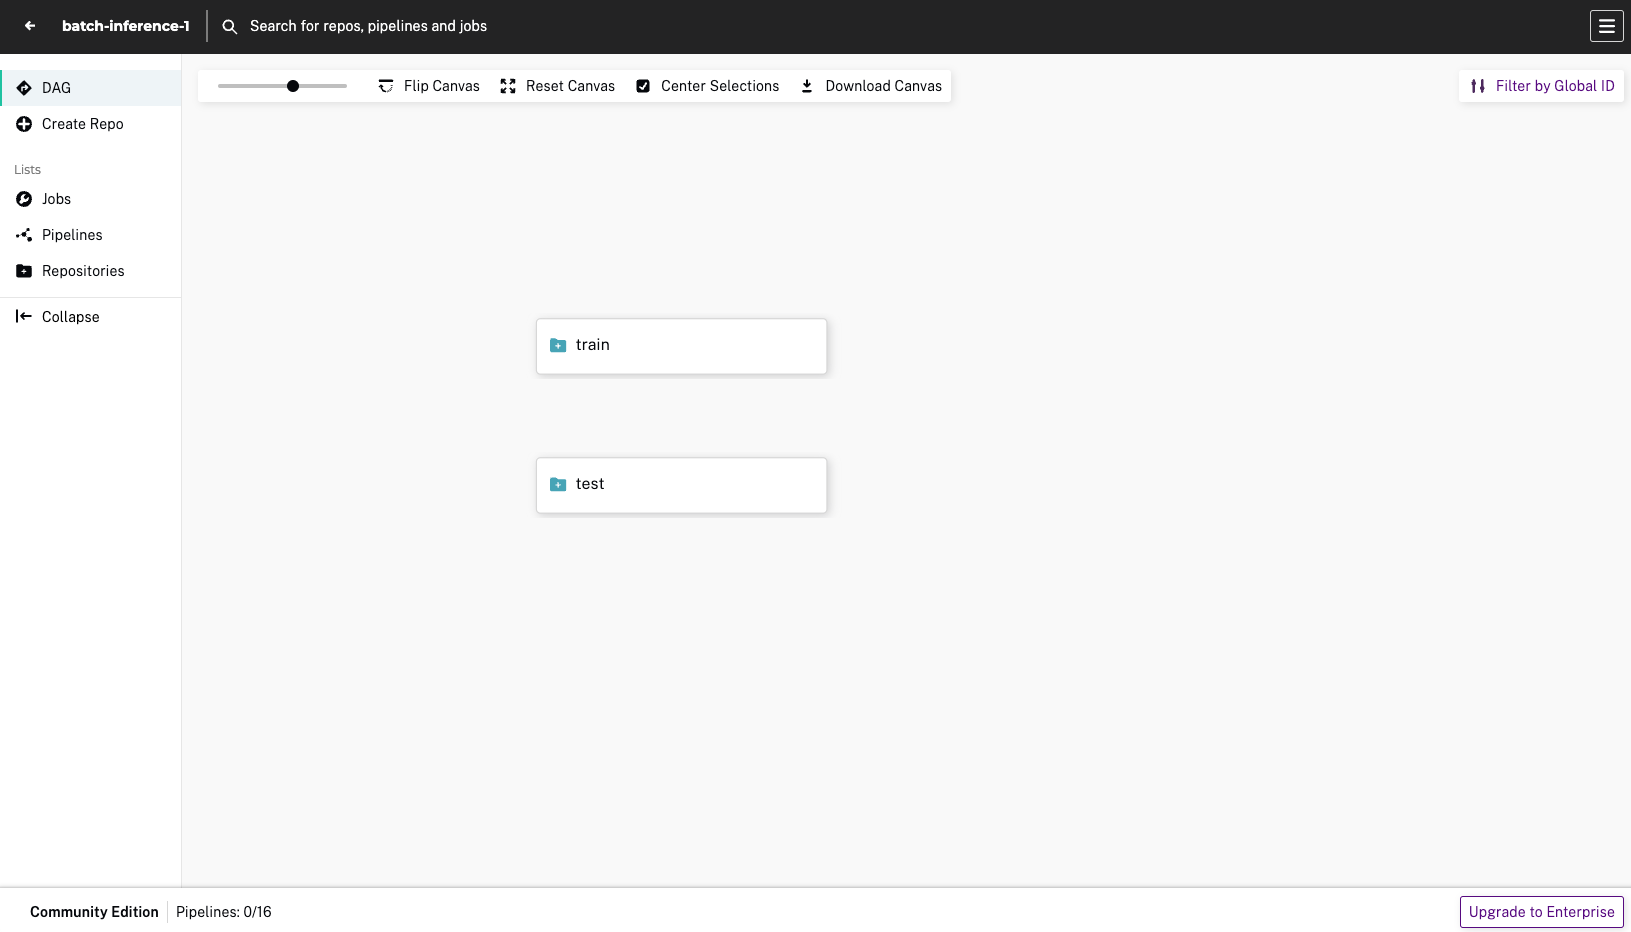

# Create a pipeline for training data
Our pipeline will merge the data from the train/test repos and compress them into a tar file for easy data access. This would also be a good place to do any data cleanup or transformations.

In [43]:
!pachctl create pipeline -f ./pachyderm/pipelines/compress/compress.json

In [44]:
!pachctl list pipeline

PROJECT           NAME     VERSION INPUT                                                  CREATED       STATE / LAST JOB DESCRIPTION                                                          
batch-inference-1 compress 1       (batch-inference-1/train:/ ⨯ batch-inference-1/test:/) 2 seconds ago running / -      A pipeline that compresses images from the train and test data sets. 


In [45]:
!pachctl list repo

PROJECT           NAME     CREATED       SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 compress 5 seconds ago ≤ 0B          Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    2 minutes ago ≤ 0B                                                               
batch-inference-1 test     2 minutes ago ≤ 0B                                                               


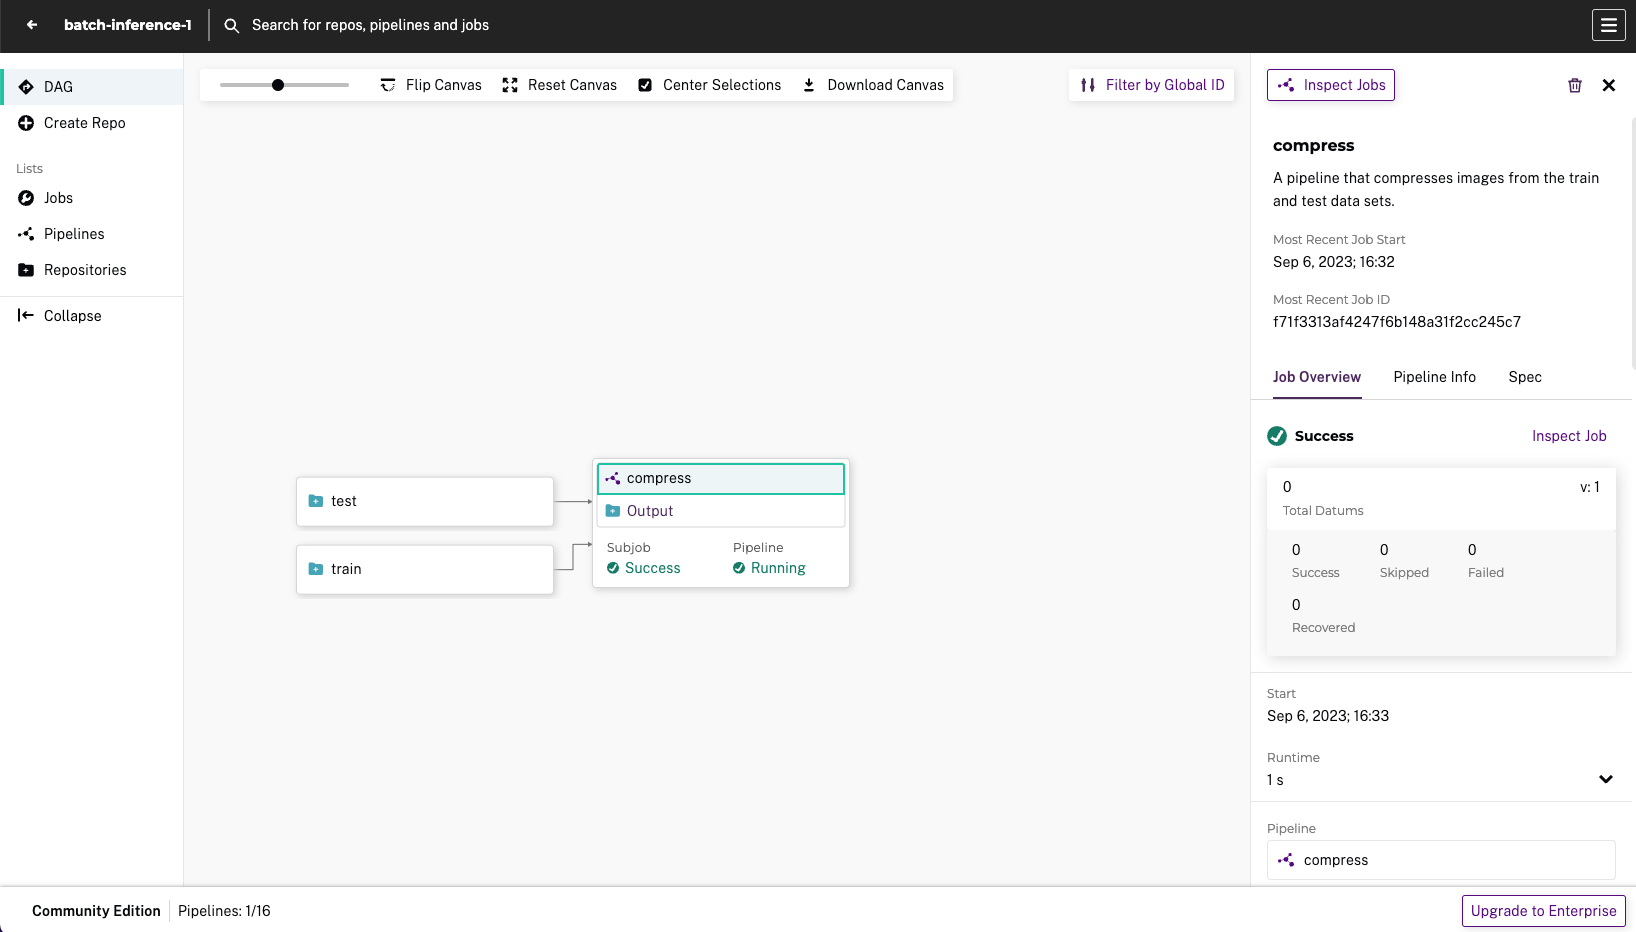

# Add data to the train and test repos
Adding files to the train or test repos will send them through the compress pipeline and produce a single tar file.

In [ ]:
!pachctl put file -r train@master:/ -f ./data/train_1000

In [ ]:
!pachctl put file -r test@master:/ -f ./data/test_1000

In [48]:
!pachctl list repo

PROJECT           NAME     CREATED       SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 compress 2 minutes ago ≤ 21.13MiB    Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    5 minutes ago ≤ 17.36MiB                                                         
batch-inference-1 test     5 minutes ago ≤ 4.207MiB                                                         


# Use the compress repo data to train our models
We'll use a Determined cluster to train our model based on the data stored and versioned in Pachyderm. We'll need to tell Determined the Pachyderm host, port, project, repo, and branch so it knows where to download the data we care about. When creating the experiment, change the Pachyderm host and port to the host and port of your Pachyderm cluster.

In [52]:
!cat ./determined/train.yaml

description: catdog_single_train
data:
  pachyderm:
    host: PACHD_HOST
    port: PACHD_PORT
    project: batch-inference-1
    repo: compress
    branch: master
hyperparameters:
  learning_rate: 0.005
  global_batch_size: 16
  weight_decay: 1.0e-4
  nesterov: true
searcher:
  name: single
  metric: accuracy
  max_length:
    batches: 100
  smaller_is_better: false
entrypoint: model_def:CatDogModel
scheduling_unit: 10
min_validation_period:
  batches: 10


In [51]:
!kubectl get services

pachd                       ClusterIP      10.105.140.72    <none>        30650/TCP,30657/TCP,30658/TCP,30600/TCP,30656/TCP


In [53]:
!det experiment create ./determined/train.yaml ./determined --config data.pachyderm.host=host.docker.internal --config data.pachyderm.port=30650

Preparing files to send to master... 19.0KB and 11 files
Created experiment 10


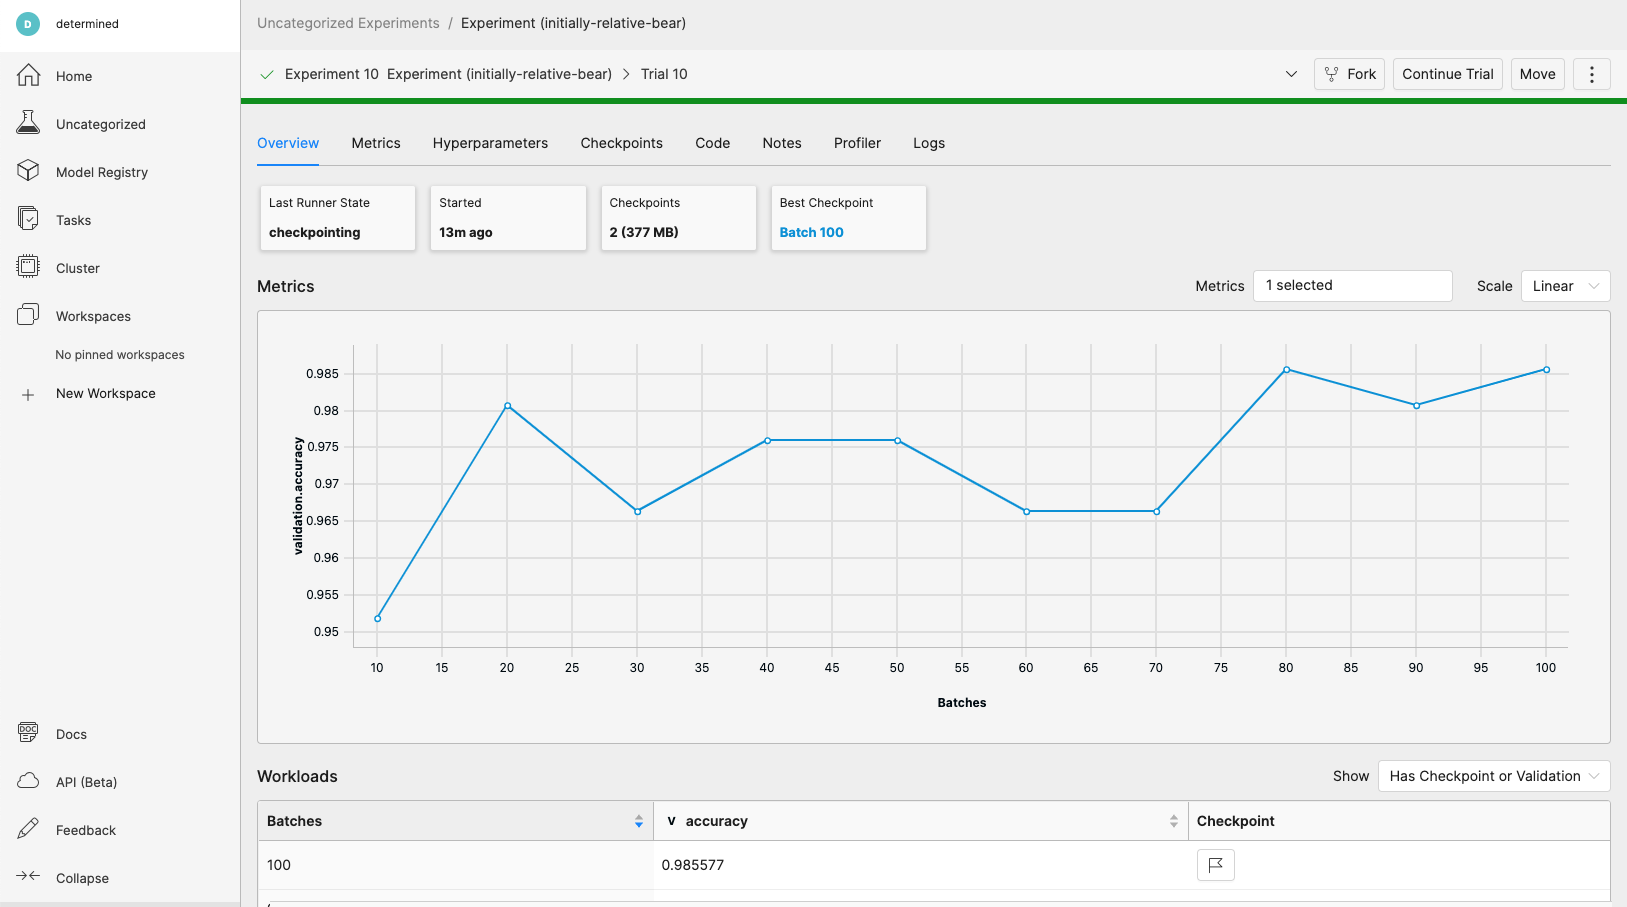

# Download checkpoints from Determined
Once we are happy with our model's performance, we will download the best checkpoint and put it in a Pachyderm repo. You'll change the trial id to the trial that just completed.

In [68]:
!det trial download 10 --latest -o ./data/checkpoints/catdog1000

Local checkpoint path:
data/checkpoints/catdog1000 

   Experiment ID |   Trial ID |   Steps Completed | Report Time              | Checkpoint UUID                      | Validation Metrics                      | Metadata
-----------------+------------+-------------------+--------------------------+--------------------------------------+-----------------------------------------+--------------------------------------
              10 |         10 |                80 | 2023-09-06 20:51:57+0000 | 5920e901-1abf-4eef-af21-4bf4282aafc5 | {                                       | {
                 |            |                   |                          |                                      |     "avgMetrics": {                     |     "determined_version": "0.25.0",
                 |            |                   |                          |                                      |         "accuracy": 0.9855769230769231, |     "format": "pickle",
                 |            |       

In [69]:
!pachctl create repo models

In [70]:
!pachctl list repo

PROJECT           NAME     CREATED        SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 models   2 seconds ago  ≤ 0B                                                               
batch-inference-1 compress 38 minutes ago ≤ 21.13MiB    Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    40 minutes ago ≤ 17.36MiB                                                         
batch-inference-1 test     41 minutes ago ≤ 4.207MiB                                                         


In [ ]:
!pachctl put file -r models@master:/catdog1000 -f ./data/checkpoints/catdog1000

# Create a repo and pipeline for inferencing
Using the Determined model, we'll create a pipeline that can predict batches of files. We can also scale this step out by adding a parallelism_spec value to our pipeline spec. 

In [72]:
!pachctl create repo predict

In [73]:
!pachctl list repo

PROJECT           NAME     CREATED        SIZE (MASTER) DESCRIPTION                                          
batch-inference-1 predict  2 seconds ago  ≤ 0B                                                               
batch-inference-1 models   36 seconds ago ≤ 179.8MiB                                                         
batch-inference-1 compress 38 minutes ago ≤ 21.13MiB    Output repo for pipeline batch-inference-1/compress. 
batch-inference-1 train    41 minutes ago ≤ 17.36MiB                                                         
batch-inference-1 test     41 minutes ago ≤ 4.207MiB                                                         


In [74]:
!pachctl create pipeline -f ./pachyderm/pipelines/predict/predict.json

In [76]:
!pachctl list pipeline

PROJECT           NAME           VERSION INPUT                                                        CREATED        STATE / LAST JOB  DESCRIPTION                                                                              
batch-inference-1 predict-catdog 1       (batch-inference-1/predict:/* ⨯ batch-inference-1/models:/*) 50 seconds ago running / success A pipeline that classifies images from the predict repo using models in the models repo. 
batch-inference-1 compress       1       (batch-inference-1/train:/ ⨯ batch-inference-1/test:/)       39 minutes ago running / success A pipeline that compresses images from the train and test data sets.                     


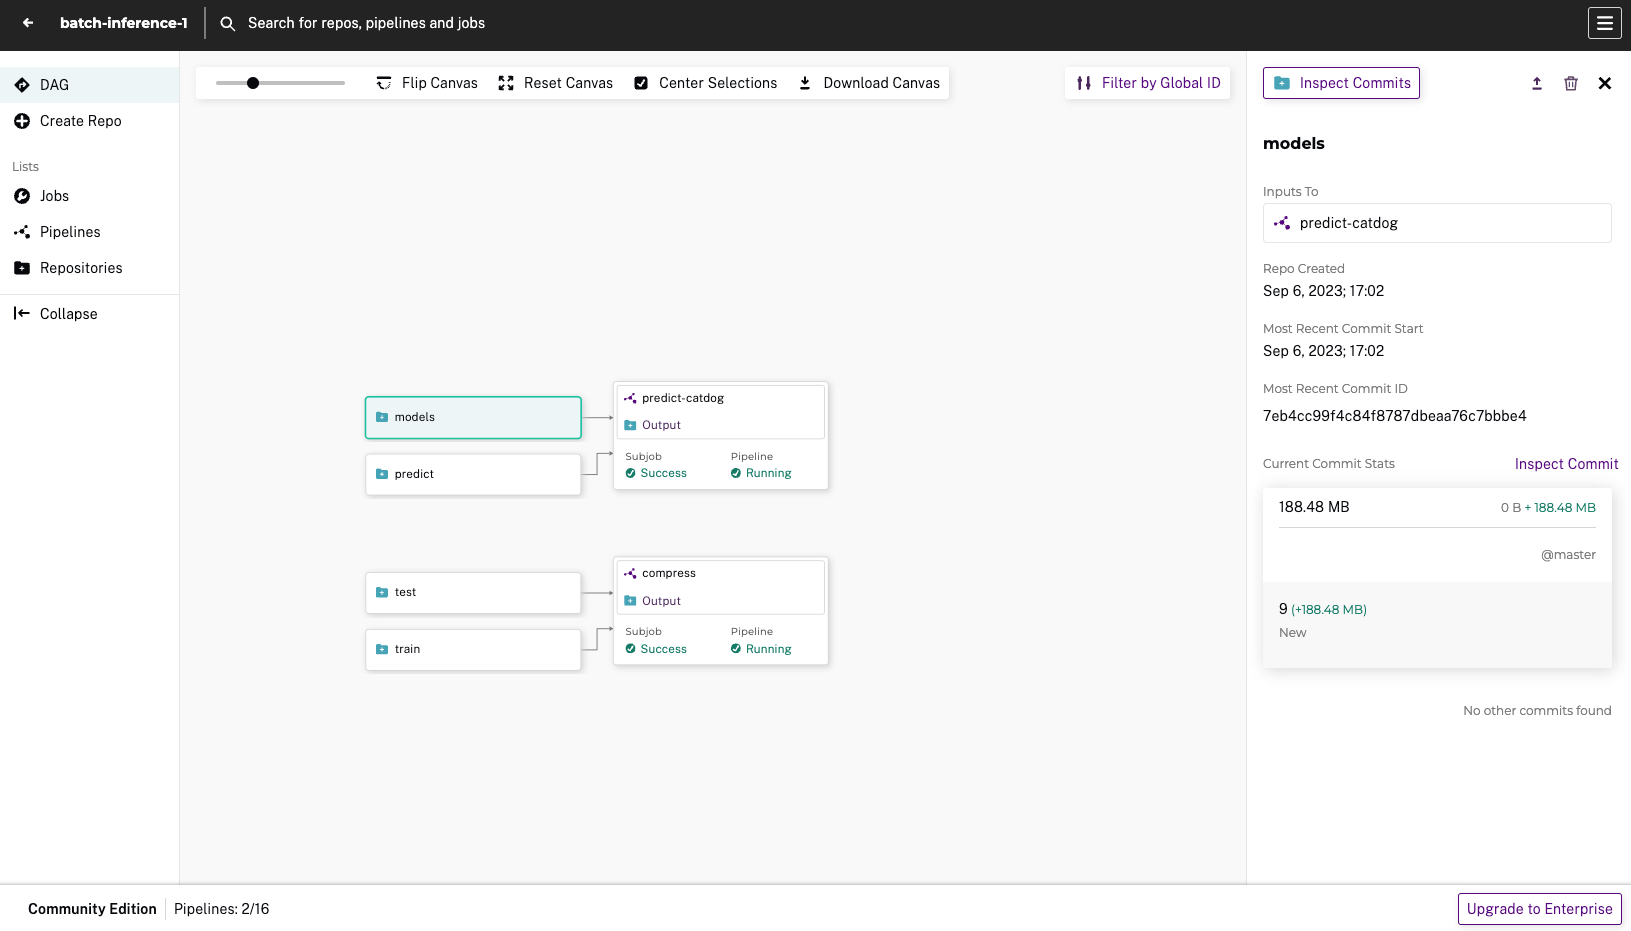

# Add some files for Pachyderm/Determined to inference
We can add any number of files to the predict repo at any time. Our pipelines will both generate an image as output and store the result as a csv row

In [ ]:
!pachctl put file -r predict@master -f ./data/predict/batch_10

# Add a results pipeline
The results pipeline will collect all of the predctions and output various charts and a database.

In [80]:
!pachctl create pipeline -f ./pachyderm/pipelines/results/results.json

In [81]:
!pachctl list pipeline

PROJECT           NAME           VERSION INPUT                                                        CREATED        STATE / LAST JOB  DESCRIPTION                                                                              
batch-inference-1 results        1       batch-inference-1/predict-catdog:/                           3 seconds ago  running / -       A pipeline that merges results from the predict pipelines.                               
batch-inference-1 predict-catdog 1       (batch-inference-1/predict:/* ⨯ batch-inference-1/models:/*) 3 minutes ago  running / success A pipeline that classifies images from the predict repo using models in the models repo. 
batch-inference-1 compress       1       (batch-inference-1/train:/ ⨯ batch-inference-1/test:/)       42 minutes ago running / success A pipeline that compresses images from the train and test data sets.                     


# Add more files to watch all of the prediction and results pipelines run

In [ ]:
!pachctl put file -r predict@master -f ./data/predict/batch_5_2

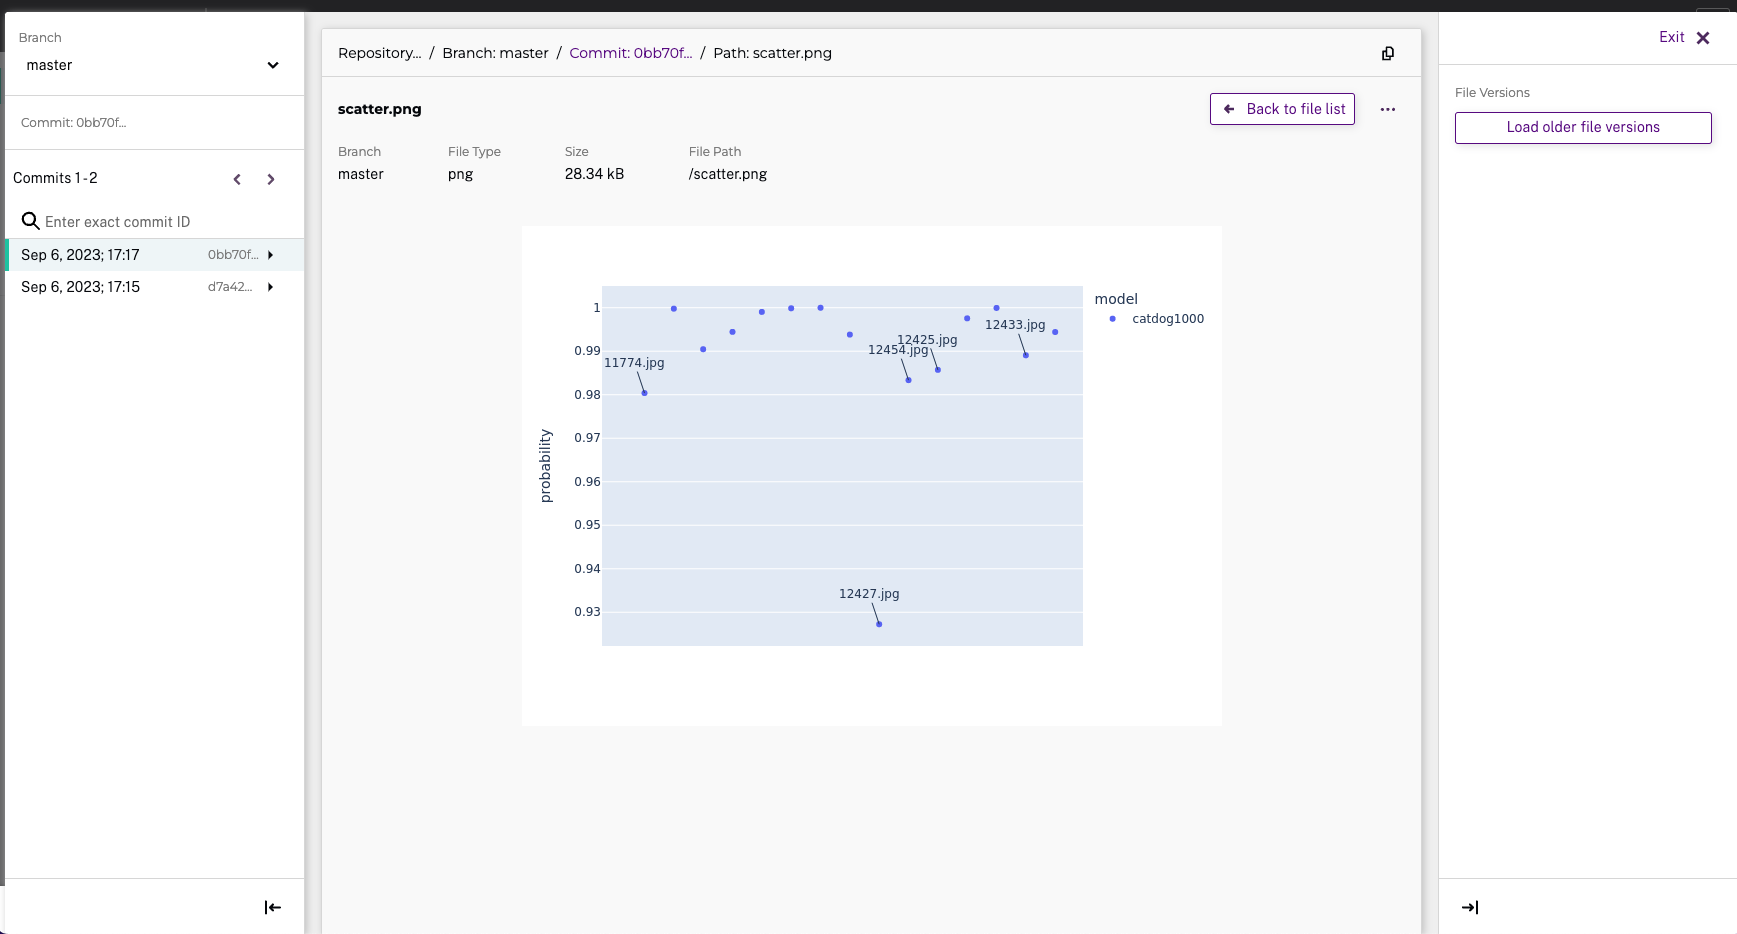